# Run temperature attributions and save out

1. Run one scenario emissions driven. Save out the following forcing categories:

- All forcing
- All minus GHGs
- All minus aerosols
- All minus other anthropogenic
- All minus natural

2. re-run forcing-driven scenarios with the above.

In [1]:
import os

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
pl.style.use('../defaults.mplstyle')

In [3]:
output_ensemble_size=841

In [4]:
scenarios = ["all"]

In [5]:
df_solar = pd.read_csv(
    "../data/forcing/solar_erf_timebounds.csv", index_col="year"
)
df_volcanic = pd.read_csv(
    "../data/forcing/volcanic_ERF_1750-2101_timebounds.csv",
    index_col="timebounds",
)

# Normally, we adjust the efficacy of volcanic forcing, but here we calculate temperatures from forcing, so adjust the forcing directly.
volcanic_forcing = df_volcanic["erf"].loc[1750:2023].values * 0.6
solar_forcing = df_solar["erf"].loc[1750:2023].values

trend_shape = np.ones(274)
trend_shape[:271] = np.linspace(0, 1, 271)

In [6]:
df_methane_141 = pd.read_csv(
    "../data/calibration/v1.4.1/CH4_lifetime.csv",
    index_col=0,
)
df_configs_141 = pd.read_csv(
    "../data/calibration/v1.4.1/calibrated_constrained_parameters.csv",
    index_col=0,
)
df_landuse_141 = pd.read_csv(
    "../data/calibration/v1.4.1/landuse_scale_factor.csv",
    index_col=0,
)
df_lapsi_141 = pd.read_csv(
    "../data/calibration/v1.4.1/lapsi_scale_factor.csv",
    index_col=0,
)

In [7]:
configs = df_configs_141.index

## First, emissions-driven run

In [8]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2023, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
species, properties = read_properties()
species.remove("Halon-1202")
species.remove("NOx aviation")
species.remove("Contrails")
f.define_species(species, properties)
f.allocate()

### Get emissions into fair

copy across the baseline emissions from ssp245 into all scenarios (baseline scenario doesn't matter as they are the same up to 2022)

In [9]:
da_emissions_141 = xr.load_dataarray(
    "../data/emissions/v1.4.1/ssps_harmonized_1750-2499.nc"
)
da = da_emissions_141.loc[
    dict(config="unspecified", scenario="ssp245", timepoints=np.arange(1750.5, 2023))
].drop_vars(("scenario", "config"))

for config in configs:
    for scenario in scenarios:
        f.emissions.loc[dict(scenario=scenario, config=config)] = da

In [10]:
f.emissions

<xarray.DataArray (timepoints: 273, scenario: 1, config: 841, specie: 61)>
array([[[[9.30608418e-03, 1.09921738e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608418e-03, 1.09921738e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608418e-03, 1.09921738e-02,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [9.30608418e-03, 1.09921738e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608418e-03, 1.09921738e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608418e-03, 1.09921738e-02,            nan, ...,
                     nan,            nan,            nan]]],


       [[[9.40737778e-03, 3.29765215e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.40737778e-03, 3.29765215e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.40737778e-03, 3.29765215e-02,            nan, ...,
...
                     nan,            nan,            nan],
         [3.68171247e+01, 4.32164643e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.68171247e+01, 4.32164643e+00,            nan, ...,
                     nan,            nan,            nan]]],


       [[[3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.022e+03 2.022e+03
  * scenario    (scenario) <U3 'all'
  * config      (config) int64 4004 4859 5066 10022 ... 1595131 1595968 1596050
  * specie      (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospher...

### Fill in all the configs

In [11]:
# solar and volcanic forcing
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs_141["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs_141["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs_141["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)
# climate response
fill(
    f.climate_configs["ocean_heat_capacity"],
    df_configs_141.loc[:, "clim_c1":"clim_c3"].values,
)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs_141.loc[:, "clim_kappa1":"clim_kappa3"].values,
)  # not massively robust, since relies on kappa1, kappa2, kappa3 being in adjacent cols
fill(
    f.climate_configs["deep_ocean_efficacy"],
    df_configs_141["clim_epsilon"].values.squeeze(),
)
fill(
    f.climate_configs["gamma_autocorrelation"],
    df_configs_141["clim_gamma"].values.squeeze(),
)
fill(f.climate_configs["sigma_eta"], df_configs_141["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs_141["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs_141["seed"])
fill(f.climate_configs["stochastic_run"], False)
fill(f.climate_configs["use_seed"], False)
fill(f.climate_configs["forcing_4co2"], df_configs_141["clim_F_4xCO2"])

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs_141["cc_r0"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_airborne"],
    df_configs_141["cc_rA"].values.squeeze(),
    specie="CO2",
)
fill(
    f.species_configs["iirf_uptake"], df_configs_141["cc_rU"].values.squeeze(), specie="CO2"
)
fill(
    f.species_configs["iirf_temperature"],
    df_configs_141["cc_rT"].values.squeeze(),
    specie="CO2",
)

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs_141["aci_beta"].values.squeeze())
fill(
    f.species_configs["aci_shape"],
    df_configs_141["aci_shape_so2"].values.squeeze(),
    specie="Sulfur",
)
fill(
    f.species_configs["aci_shape"],
    df_configs_141["aci_shape_bc"].values.squeeze(),
    specie="BC",
)
fill(
    f.species_configs["aci_shape"],
    df_configs_141["aci_shape_oc"].values.squeeze(),
    specie="OC",
)

# methane lifetime baseline and sensitivity
fill(
    f.species_configs["unperturbed_lifetime"],
    df_methane_141.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane_141.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane_141.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane_141.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane_141.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane_141.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f.species_configs["lifetime_temperature_sensitivity"],
    df_methane_141.loc["historical_best", "temp"],
)

# correct land use  and LAPSI scale factor terms
fill(
    f.species_configs["land_use_cumulative_emissions_to_forcing"],
    df_landuse_141.loc["historical_best", "CO2_AFOLU"],
    specie="CO2 AFOLU",
)
fill(
    f.species_configs["lapsi_radiative_efficiency"],
    df_lapsi_141.loc["historical_best", "BC"],
    specie="BC",
)

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
# might wanna run pulse expts with these gases)
fill(f.species_configs["baseline_emissions"], 38.246272, specie="CH4")
fill(f.species_configs["baseline_emissions"], 0.92661989, specie="N2O")
fill(f.species_configs["baseline_emissions"], 19.41683292, specie="NOx")
fill(f.species_configs["baseline_emissions"], 2.293964929, specie="Sulfur")
fill(f.species_configs["baseline_emissions"], 348.4549732, specie="CO")
fill(f.species_configs["baseline_emissions"], 60.62284009, specie="VOC")
fill(f.species_configs["baseline_emissions"], 2.096765609, specie="BC")
fill(f.species_configs["baseline_emissions"], 15.44571911, specie="OC")
fill(f.species_configs["baseline_emissions"], 6.656462698, specie="NH3")
fill(f.species_configs["baseline_emissions"], 0.92661989, specie="N2O")
fill(f.species_configs["baseline_emissions"], 0.02129917, specie="CCl4")
fill(f.species_configs["baseline_emissions"], 202.7251231, specie="CHCl3")
fill(f.species_configs["baseline_emissions"], 211.0095537, specie="CH2Cl2")
fill(f.species_configs["baseline_emissions"], 4544.519056, specie="CH3Cl")
fill(f.species_configs["baseline_emissions"], 111.4920237, specie="CH3Br")
fill(f.species_configs["baseline_emissions"], 0.008146006, specie="Halon-1211")
fill(f.species_configs["baseline_emissions"], 0.000010554155, specie="SO2F2")
fill(f.species_configs["baseline_emissions"], 0, specie="CF4")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f.species_configs["erfari_radiative_efficiency"],
        df_configs_141[f"ari_{specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs_141[f"fscale_{specie}"].values.squeeze(),
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs_141["fscale_minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f.species_configs["ozone_radiative_efficiency"],
        df_configs_141[f"o3_{specie}"],
        specie=specie,
    )

# # tune down volcanic efficacy
# fill(f.species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs_141["cc_co2_concentration_1750"].values.squeeze(),
    specie="CO2",
)

# initial conditions
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [12]:
f.run()

Running 841 projections in parallel:   0%|          | 0/273 [00:00<?, ?timesteps/s]

## Now isolate out forcing cats

In [13]:
f.species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'BC',
 'OC',
 'NH3',
 'NOx',
 'VOC',
 'CO',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee',
 'Solar',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
 'Ozone',
 'Light absorbing particles on snow and ice',
 'Stratospheric water vapour',
 'Land use',
 'Equivalent effective stratospheric chlorine']

In [14]:
ghgs = [
 'CO2',
 'CH4',
 'N2O',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee',
]

In [15]:
aerosols = [
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
]

In [16]:
natural = [
 'Solar',
 'Volcanic',
]

In [17]:
other = [
 'Ozone',
 'Light absorbing particles on snow and ice',
 'Stratospheric water vapour',
 'Land use',
]

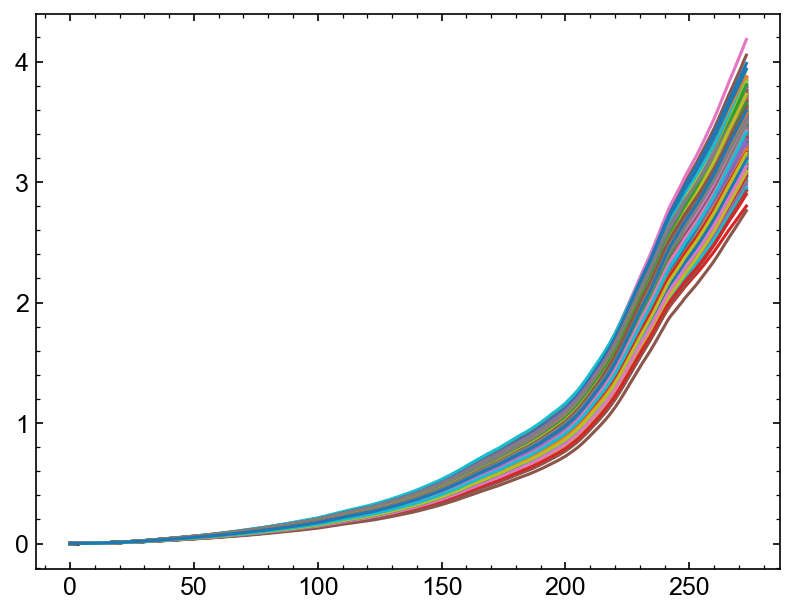

In [18]:
pl.plot(f.forcing.sel(specie=ghgs).sum(dim='specie').sel(scenario='all'));

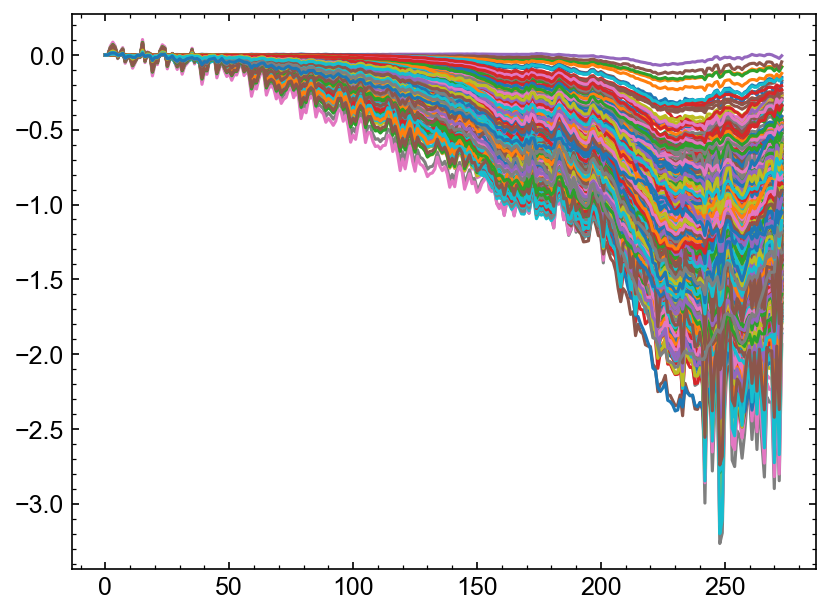

In [19]:
pl.plot(f.forcing.sel(specie=aerosols).sum(dim='specie').sel(scenario='all'));

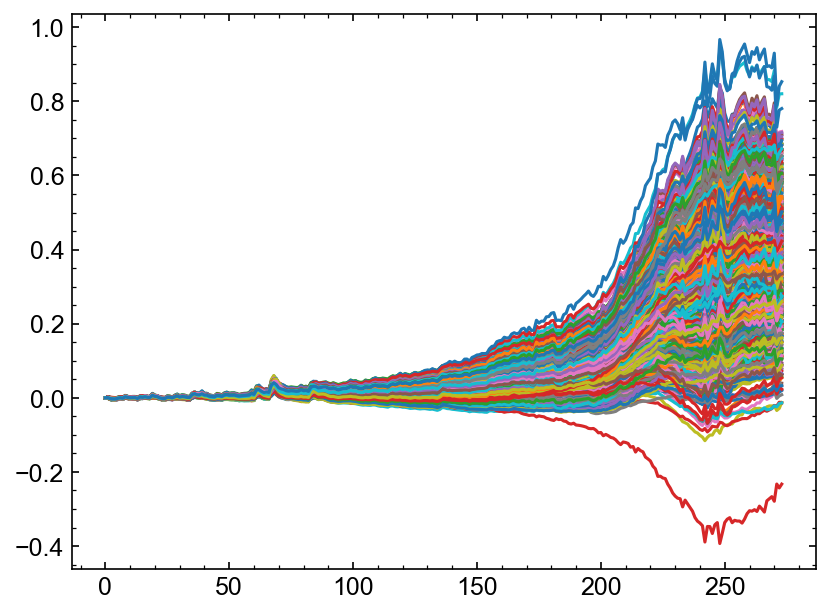

In [20]:
pl.plot(f.forcing.sel(specie=other).sum(dim='specie').sel(scenario='all'));

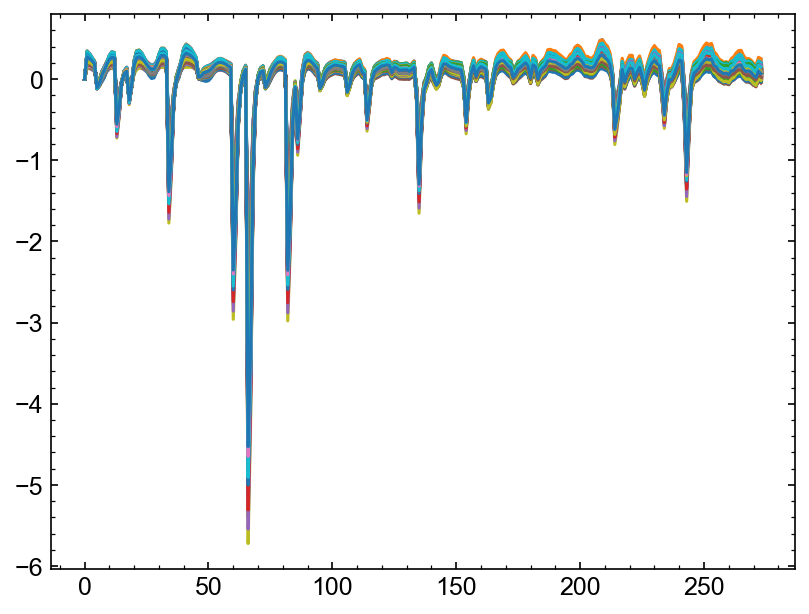

In [21]:
pl.plot(f.forcing.sel(specie=natural).sum(dim='specie').sel(scenario='all'));

### Check linearity

note y-axis value very small - minimal floating point differences are fine

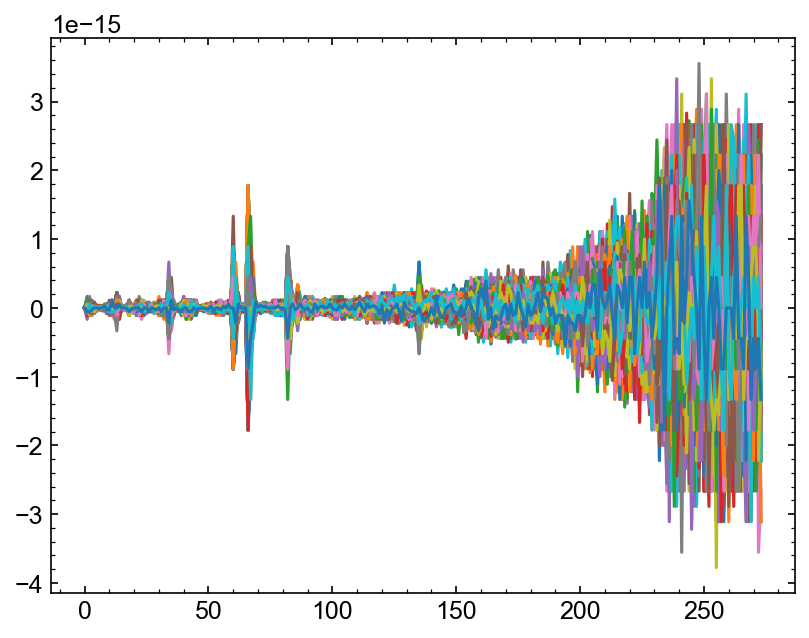

In [22]:
pl.plot(
    f.forcing_sum.sel(scenario='all') - (
        f.forcing.sel(specie=ghgs).sum(dim='specie').sel(scenario='all') +
        f.forcing.sel(specie=aerosols).sum(dim='specie').sel(scenario='all') +
        f.forcing.sel(specie=other).sum(dim='specie').sel(scenario='all') + 
        f.forcing.sel(specie=natural).sum(dim='specie').sel(scenario='all')
    )
);

In [23]:
scenarios = ["all", "no_ghgs", "no_aerosols", "no_other", "no_natural"]

In [24]:
ff = FAIR()
ff.define_time(1750, 2023, 1)
ff.define_scenarios(scenarios)
ff.define_configs(configs)

species = ["bulk"]
properties = {
    "bulk": {
        "type": "unspecified",
        "input_mode": "forcing",
        "greenhouse_gas": False,
        "aerosol_chemistry_from_emissions": False,
        "aerosol_chemistry_from_concentration": False,
    }
}

ff.define_species(species, properties)
ff.allocate()

### Create forcing-driven time series

In [25]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=ghgs).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_ghgs"
)

In [26]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=aerosols).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_aerosols"
)

In [27]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=other).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_other"
)

In [28]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=natural).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_natural"
)

In [29]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all'),
    specie="bulk",
    scenario="all"
)

### fill and initialise configs

In [30]:
# climate response
fill(
    ff.climate_configs["ocean_heat_capacity"],
    df_configs_141.loc[:, "clim_c1":"clim_c3"].values,
)
fill(
    ff.climate_configs["ocean_heat_transfer"],
    df_configs_141.loc[:, "clim_kappa1":"clim_kappa3"].values,
)  # not massively robust, since relies on kappa1, kappa2, kappa3 being in adjacent cols
fill(
    ff.climate_configs["deep_ocean_efficacy"],
    df_configs_141["clim_epsilon"].values.squeeze(),
)
fill(
    ff.climate_configs["gamma_autocorrelation"],
    df_configs_141["clim_gamma"].values.squeeze(),
)
fill(ff.climate_configs["sigma_eta"], df_configs_141["clim_sigma_eta"].values.squeeze())
fill(ff.climate_configs["sigma_xi"], df_configs_141["clim_sigma_xi"].values.squeeze())
fill(ff.climate_configs["seed"], df_configs_141["seed"])
fill(ff.climate_configs["stochastic_run"], False)
fill(ff.climate_configs["use_seed"], False)
fill(ff.climate_configs["forcing_4co2"], df_configs_141["clim_F_4xCO2"])

# initial conditions
initialise(ff.forcing, 0)
initialise(ff.temperature, 0)

In [31]:
ff.run()

Running 4205 projections in parallel:   0%|          | 0/273 [00:00<?, ?timesteps/s]

In [32]:
base = np.arange(1850, 1901)
temp_ghgs = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_ghgs", layer=0) - ff.temperature.sel(scenario="no_ghgs", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_aerosols = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_aerosols", layer=0) - ff.temperature.sel(scenario="no_aerosols", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_natural = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_natural", layer=0) - ff.temperature.sel(scenario="no_natural", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_other = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_other", layer=0) - ff.temperature.sel(scenario="no_other", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_all = ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')

In [33]:
df_obs = pd.read_csv('../data/observations/IGCC_GMST_1850-2022.csv', index_col=0)
df_obs

,gmst
time,
1850.5,-0.053137
1851.5,0.056863
1852.5,0.084363
1853.5,0.049363
1854.5,0.049363
...,...
2018.5,1.109363
2019.5,1.236863
2020.5,1.269363


## Gillett et al. (2021) style plot

fig 1 b in https://www.nature.com/articles/s41558-020-00965-9

Note the ranges coming out of fair are much more constrained than CMIP6 models in Gillett et al., since the historical climate record and emergent climate metrics are constrained on observations and AR6 assessment (by the fair-calibrate ensemble).

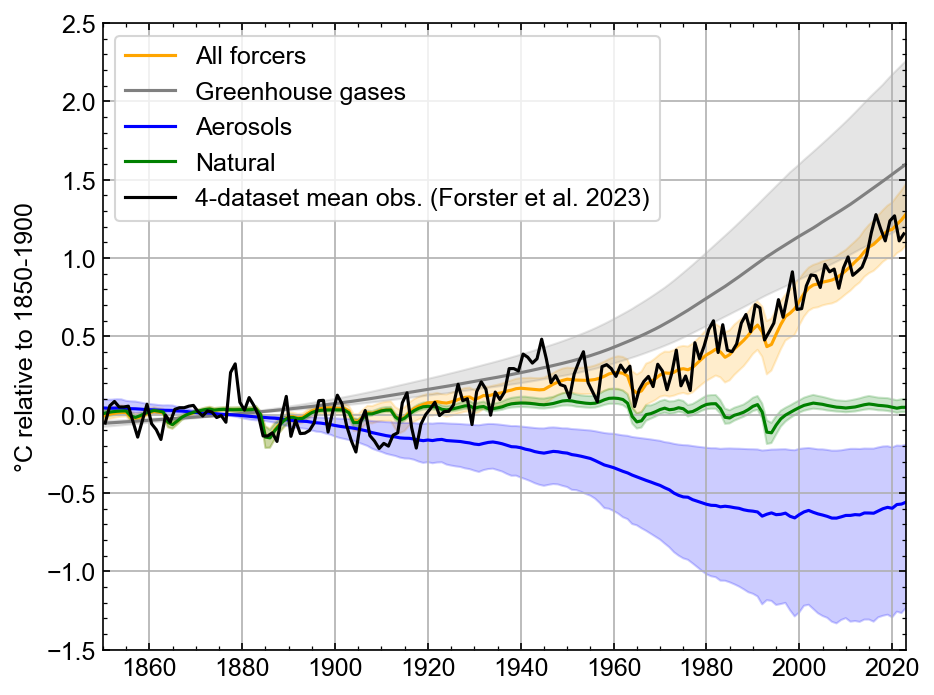

In [34]:
pl.fill_between(np.arange(1750, 2024), temp_all.quantile(0.05, dim="config"), temp_all.quantile(0.95, dim="config"), color='orange', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2024), temp_all.median(dim="config"), color='orange', label='All forcers');

pl.fill_between(np.arange(1750, 2024), temp_ghgs.quantile(0.05, dim="config"), temp_ghgs.quantile(0.95, dim="config"), color='0.5', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2024), temp_ghgs.median(dim="config"), color='0.5', label='Greenhouse gases');

pl.fill_between(np.arange(1750, 2024), temp_aerosols.quantile(0.05, dim="config"), temp_aerosols.quantile(0.95, dim="config"), color='blue', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2024), temp_aerosols.median(dim="config"), color='blue', label='Aerosols');

#pl.plot(np.arange(1750, 2024), temp_other.median(dim="config"), color='green')

pl.fill_between(np.arange(1750, 2024), temp_natural.quantile(0.05, dim="config"), temp_natural.quantile(0.95, dim="config"), color='green', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2024), temp_natural.median(dim="config"), color='green', label='Natural');
pl.plot(df_obs.gmst, color='k', label='4-dataset mean obs. (Forster et al. 2023)')

pl.ylabel('°C relative to 1850-1900')
pl.legend();
pl.grid()

pl.xlim(1850, 2023)
pl.ylim(-1.5, 2.5)

os.makedirs('../plots/', exist_ok=True)
pl.tight_layout()
pl.savefig('../plots/attributed_warming_rel1850-1900.png')

In [35]:
temp_aerosols.median(dim="config")

<xarray.DataArray (timebounds: 274)>
array([ 0.08182892,  0.08182889,  0.08266807,  0.08364688,  0.08377373,
        0.08284951,  0.08274839,  0.08316425,  0.08195646,  0.08122154,
        0.08073108,  0.0801017 ,  0.0797198 ,  0.0800733 ,  0.08046239,
        0.08259396,  0.08155349,  0.08165245,  0.08192405,  0.07916038,
        0.07906156,  0.0787221 ,  0.08000021,  0.08144112,  0.08236931,
        0.08046571,  0.079974  ,  0.08039465,  0.0798624 ,  0.07854802,
        0.0786131 ,  0.07811903,  0.07768958,  0.07774905,  0.07812241,
        0.0796069 ,  0.07873503,  0.07882374,  0.07841585,  0.07581914,
        0.07574628,  0.07522237,  0.07638961,  0.07714037,  0.07801758,
        0.0762623 ,  0.07587357,  0.07645594,  0.07596449,  0.07449561,
        0.0743657 ,  0.07386392,  0.07361053,  0.07356766,  0.07404869,
        0.07464029,  0.07396105,  0.07354555,  0.07269902,  0.07051323,
        0.07014131,  0.06940026,  0.06984306,  0.07061403,  0.0706309 ,
        0.06934428,  0.06849203,  0.06818058,  0.06772812,  0.06631774,
        0.06605989,  0.06477094,  0.06394176,  0.06395135,  0.0646287 ,
        0.06480094,  0.06356391,  0.06382212,  0.06290759,  0.06039603,
        0.05993928,  0.05867887,  0.05907727,  0.05947087,  0.05938525,
        0.05740408,  0.05681308,  0.0561164 ,  0.05514941,  0.05329761,
        0.05238876,  0.05154716,  0.05064136,  0.05024975,  0.05107351,
        0.05100472,  0.04946373,  0.04900073,  0.04736927,  0.04452649,
...
       -0.16713883, -0.16918066, -0.17120193, -0.1762174 , -0.18028918,
       -0.18740522, -0.19076566, -0.18345198, -0.17691683, -0.17413823,
       -0.17899936, -0.18567205, -0.19485639, -0.20416166, -0.2056803 ,
       -0.21095396, -0.22002814, -0.22598751, -0.23533797, -0.24129889,
       -0.24529291, -0.23986205, -0.23420593, -0.23650622, -0.24197745,
       -0.24519013, -0.2547057 , -0.25915415, -0.26523628, -0.27215456,
       -0.27953741, -0.29265995, -0.30717616, -0.32095315, -0.32909286,
       -0.3380879 , -0.34966084, -0.36155283, -0.37148709, -0.38545026,
       -0.39670631, -0.40819133, -0.41938486, -0.42966274, -0.44095816,
       -0.45130918, -0.46630392, -0.47929623, -0.50049601, -0.51485892,
       -0.52479459, -0.52671172, -0.54226621, -0.55224055, -0.562176  ,
       -0.57172819, -0.57827751, -0.5794686 , -0.58798185, -0.58430741,
       -0.5878383 , -0.5934726 , -0.59754298, -0.60698306, -0.61263517,
       -0.61569239, -0.62082786, -0.64747727, -0.63527685, -0.62675982,
       -0.63806339, -0.63579435, -0.62838455, -0.64842534, -0.65870533,
       -0.63759343, -0.62062145, -0.61101634, -0.62305562, -0.63309386,
       -0.64043414, -0.64886535, -0.65991783, -0.66012492, -0.65203771,
       -0.64301507, -0.6428048 , -0.63783223, -0.63974382, -0.62723925,
       -0.62746213, -0.6288823 , -0.61464109, -0.60007518, -0.59135081,
       -0.59722134, -0.57350861, -0.57037228, -0.55789359])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.751e+03 ... 2.022e+03 2.023e+03
    layer       int64 0

In [36]:
df_out = pd.DataFrame(
    np.array(
        [
            temp_ghgs.quantile(0.05, dim="config").data,
            temp_ghgs.median(dim="config").data,
            temp_ghgs.quantile(0.95, dim="config").data,
            temp_aerosols.quantile(0.05, dim="config").data,
            temp_aerosols.median(dim="config").data,
            temp_aerosols.quantile(0.95, dim="config").data,
            temp_other.quantile(0.05, dim="config").data,
            temp_other.median(dim="config").data,
            temp_other.quantile(0.95, dim="config").data,
            temp_natural.quantile(0.05, dim="config").data,
            temp_natural.median(dim="config").data,
            temp_natural.quantile(0.95, dim="config").data,
            temp_all.quantile(0.05, dim="config").data,
            temp_all.median(dim="config").data,
            temp_all.quantile(0.95, dim="config").data,
        ]
    ).T,
    index=np.arange(1750, 2024),
    columns=['ghg_05', 'ghg_50', 'ghg_95', 'aerosol_05', 'aerosol_50', 'aerosol_95', 'other_05', 'other_50', 'other_95', 'natural_05', 'natural_50', 'natural_95', 'all_05', 'all_50', 'all_95']
)

In [37]:
os.makedirs('../output', exist_ok=True)
df_out.to_csv('../output/attributed_warming.csv')